In [1]:
import os, sys
import torch
import numpy as np

import random

from models.DAB_DETR import build_DABDETR
from util.slconfig import SLConfig
from datasets.coco import build
from util.visualizer import COCOVisualizer
from util import box_ops
from typing import Any, Callable, Dict, Iterable, List, Optional, Set, Tuple, Union

/Users/davidhajdu/Desktop/Projects/DAB-DETR/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!git clone --single-branch --branch add_dab_detr https://github.com/conditionedstimulus/transformers.git

Cloning into 'transformers'...
remote: Enumerating objects: 186332, done.
remote: Counting objects: 100% (18614/18614), done.
remote: Compressing objects: 100% (1482/1482), done.
remote: Total 186332 (delta 18222), reused 17148 (delta 17124), pack-reused 167718
Receiving objects: 100% (186332/186332), 205.42 MiB | 13.13 MiB/s, done.
Resolving deltas: 100% (134329/134329), done.ng deltas:  99% (133168/134329)
Updating files: 100% (4390/4390), done.g files:  70% (3073/4390)Updating files:  82% (3600/4390)


We provide this notebook for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or load an image from a local path(see Sec. 2).

# 0. Init and Load Pre-trained Models

In [3]:
model_config_path = "model_zoo/DAB_DETR/config.json" # change the path of the model config file
model_checkpoint_path = "model_zoo/DAB_DETR/checkpoint.pth" # change the path of the model checkpoint   
# See our Model Zoo section in README.md for more details about our pretrained models.
# https://drive.google.com/drive/folders/1pae4Yxi0H9OOFdXZg3zXuKK9yOznhTNU

In [4]:
args = SLConfig.fromfile(model_config_path)
# args['num_patterns']=4

In [5]:
model, criterion, postprocessors = build_DABDETR(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.eval()

/Users/davidhajdu/Desktop/Projects/DAB-DETR/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/davidhajdu/Desktop/Projects/DAB-DETR/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DABDETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (activation): PReLU(num_parameters=1)
        )
      )
      (query_scale): MLP(
        (layers): ModuleList(
          (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
        )
      )
    )
    (decoder): Transformer

In [6]:
args['coco_path']='/Users/davidhajdu/Desktop/data/coco'

# 1. Visualize images from dataloader
## 1.1 Load Datasets

In [7]:
dataset_val = build(image_set='val', args=args)
cocojs = dataset_val.coco.dataset
id2name = {item['id']: item['name'] for item in cocojs['categories']}

loading annotations into memory...
Done (t=2.39s)
creating index...
index created!


# 1.2 Get an Example and Visualize it

In [8]:
for x, y in dataset_val:
    if str(int(y['image_id'])) == '39769':
        cat_image = x
        data = y
        break

In [9]:
image, targets = cat_image, data

targets

{'boxes': tensor([[0.5503, 0.2765, 0.0604, 0.2215],
         [0.1695, 0.2016, 0.2080, 0.0940],
         [0.5006, 0.4933, 0.9978, 0.9865],
         [0.5008, 0.5002, 0.9983, 0.9955],
         [0.2627, 0.5456, 0.4707, 0.8646],
         [0.7715, 0.4115, 0.4570, 0.7161]]),
 'labels': tensor([75, 75, 63, 65, 17, 17]),
 'image_id': tensor([39769]),
 'area': tensor([  5887.9600,  11250.2061, 489353.8438, 837122.7500, 147967.5156,
         165732.3438]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0]),
 'orig_size': tensor([480, 640]),
 'size': tensor([ 800, 1066])}

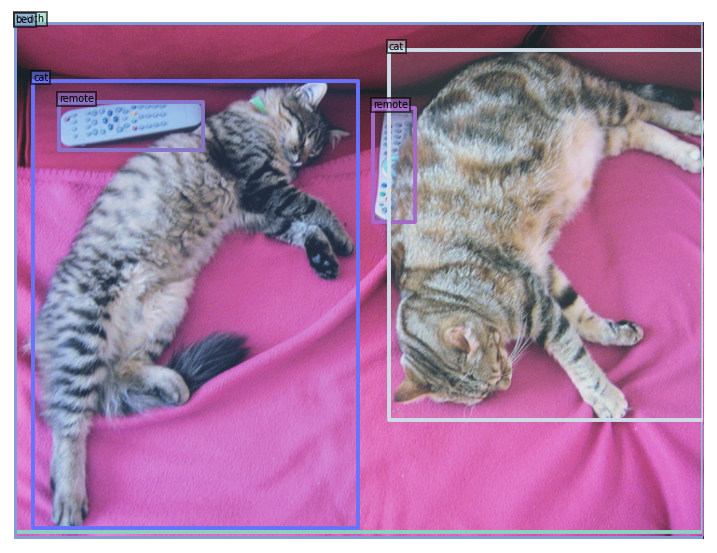

In [10]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

## 1.3 Visualize Model Predictions

In [11]:
output_ = model(image[None])
output = postprocessors['bbox'](output_, torch.Tensor([[1.0, 1.0]]))[0]

In [12]:
output_['pred_logits']

tensor([[[-10.1765,  -5.5243,  -8.9324,  ...,  -5.9117,  -7.4565,  -6.1041],
         [ -9.8138,  -5.6721,  -7.5161,  ...,  -6.5744,  -8.1244,  -8.7613],
         [-10.3054,  -5.6081,  -8.5931,  ...,  -6.0437,  -7.9185,  -7.8811],
         ...,
         [-10.2441,  -5.5455,  -8.4392,  ...,  -6.1497,  -8.2434,  -7.8669],
         [ -9.4523,  -6.0539,  -8.3190,  ...,  -6.9563,  -9.3304,  -6.0357],
         [ -9.1204,  -5.3494,  -7.3688,  ...,  -5.9933,  -6.3935,  -5.4958]]],
       grad_fn=<SelectBackward0>)

In [13]:
output_['pred_boxes']

tensor([[[0.3708, 0.3000, 0.2753, 0.3643],
         [0.5211, 0.6125, 0.9495, 0.7529],
         [0.2897, 0.6730, 0.5459, 0.6181],
         ...,
         [0.4440, 0.7868, 0.7883, 0.4039],
         [0.8856, 0.5946, 0.0505, 0.0531],
         [0.1692, 0.1981, 0.2107, 0.0975]]], grad_fn=<SelectBackward0>)

#### Huggingface postprocessing

In [14]:
def _center_to_corners_format_torch(bboxes_center: torch.Tensor) -> torch.Tensor:
    center_x, center_y, width, height = bboxes_center.unbind(-1)
    bbox_corners = torch.stack(
        # top left x, top left y, bottom right x, bottom right y
        [(center_x - 0.5 * width), (center_y - 0.5 * height), (center_x + 0.5 * width), (center_y + 0.5 * height)],
        dim=-1,
    )
    return bbox_corners

def center_to_corners_format(bboxes_center):
    """
    Converts bounding boxes from center format to corners format.

    center format: contains the coordinate for the center of the box and its width, height dimensions
        (center_x, center_y, width, height)
    corners format: contains the coodinates for the top-left and bottom-right corners of the box
        (top_left_x, top_left_y, bottom_right_x, bottom_right_y)
    """
    # Function is used during model forward pass, so we use the input framework if possible, without
    # converting to numpy
    return _center_to_corners_format_torch(bboxes_center)


def post_process_object_detection(
        logits, pred_boxes, threshold: float = 0.5, target_sizes: List[Tuple] = None, top_k: int = 100
    ):
        """
        Converts the raw output of [`DABDETRForObjectDetection`] into final bounding boxes in (top_left_x,
        top_left_y, bottom_right_x, bottom_right_y) format. Only supports PyTorch.

        Args:
            outputs ([`DetrObjectDetectionOutput`]):
                Raw outputs of the model.
            threshold (`float`, *optional*):
                Score threshold to keep object detection predictions.
            target_sizes (`torch.Tensor` or `List[Tuple[int, int]]`, *optional*):
                Tensor of shape `(batch_size, 2)` or list of tuples (`Tuple[int, int]`) containing the target size
                (height, width) of each image in the batch. If left to None, predictions will not be resized.
            top_k (`int`, *optional*, defaults to 100):
                Keep only top k bounding boxes before filtering by thresholding.

        Returns:
            `List[Dict]`: A list of dictionaries, each dictionary containing the scores, labels and boxes for an image
            in the batch as predicted by the model.
        """
        out_logits, out_bbox = logits, pred_boxes

        if target_sizes is not None:
            if len(out_logits) != len(target_sizes):
                raise ValueError(
                    "Make sure that you pass in as many target sizes as the batch dimension of the logits"
                )

        prob = out_logits.sigmoid()
        prob = prob.view(out_logits.shape[0], -1)
        k_value = min(top_k, prob.size(1))
        topk_values, topk_indexes = torch.topk(prob, k_value, dim=1)
        scores = topk_values
        topk_boxes = torch.div(topk_indexes, out_logits.shape[2], rounding_mode="floor")
        labels = topk_indexes % out_logits.shape[2]
        boxes = center_to_corners_format(out_bbox)
        boxes = torch.gather(boxes, 1, topk_boxes.unsqueeze(-1).repeat(1, 1, 4))

        # and from relative [0, 1] to absolute [0, height] coordinates
        if target_sizes is not None:
            if isinstance(target_sizes, List):
                img_h = torch.Tensor([i[0] for i in target_sizes])
                img_w = torch.Tensor([i[1] for i in target_sizes])
            else:
                img_h, img_w = target_sizes.unbind(1)
            scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1).to(boxes.device)
            boxes = boxes * scale_fct[:, None, :]

        results = []
        for s, l, b in zip(scores, labels, boxes):
            score = s[s > threshold]
            label = l[s > threshold]
            box = b[s > threshold]
            results.append({"scores": score, "labels": label, "boxes": box})

        return results

In [15]:
results = post_process_object_detection(output_['pred_logits'], output_['pred_boxes'], threshold=0.3, target_sizes=[(480, 640)])

### This is part of test_modeling_dab_detr.py file DABDETRModelIntegrationTests class expected_class variable

In [16]:
results[0]['boxes'][0, :]

tensor([ 14.6970,  49.3892, 320.5165, 469.2765], grad_fn=<SliceBackward0>)

In [17]:
thershold = 0.3 # set a threshold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

In [18]:
output['boxes']

tensor([[0.0230, 0.1029, 0.5008, 0.9777],
        [0.0642, 0.1508, 0.2709, 0.2442],
        [0.5382, 0.0405, 0.9998, 0.7664],
        ...,
        [0.0186, 0.1027, 0.5275, 0.9876],
        [0.5215, 0.1808, 0.5683, 0.3908],
        [0.0545, 0.4938, 0.9688, 0.9871]])

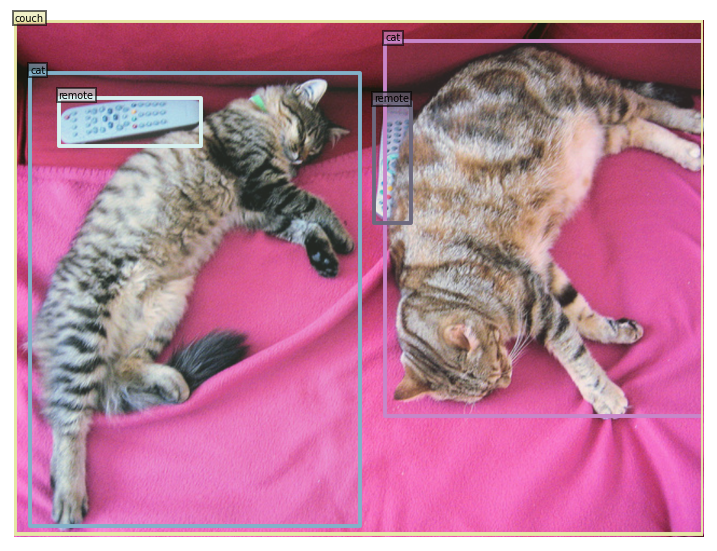

In [19]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

### Compare model outputs

In [20]:
from transformers2.src.transformers.models.dab_detr import DABDETRImageProcessor

image_processor = DABDETRImageProcessor.from_pretrained("davidhajdu/dab-detr-resnet-50")

In [21]:
from transformers2.src.transformers.models.dab_detr import DABDETRForObjectDetection
model = DABDETRForObjectDetection.from_pretrained("davidhajdu/dab-detr-resnet-50")

In [22]:
import requests
from PIL import Image

def prepare_img():
    url = "http://images.cocodataset.org/val2017/000000039769.jpg"
    im = Image.open(requests.get(url, stream=True).raw)

    return im

In [23]:
im = prepare_img()

encoding = image_processor(im, return_tensors="pt")
model.eval()
hf_outputs = model(**encoding)

In [24]:
hf_logits = hf_outputs.logits
hf_pred_boxes = hf_outputs.pred_boxes

In [25]:
output_.keys()

og_logits = output_['pred_logits']
og_pred_boxes = output_['pred_boxes']

In [26]:
print(hf_logits)

print()

print(og_logits)

tensor([[[-10.1765,  -5.5243,  -8.9324,  ...,  -5.9116,  -7.4566,  -6.1040],
         [ -9.8138,  -5.6718,  -7.5161,  ...,  -6.5739,  -8.1242,  -8.7613],
         [-10.3054,  -5.6080,  -8.5931,  ...,  -6.0436,  -7.9186,  -7.8810],
         ...,
         [-10.2441,  -5.5454,  -8.4392,  ...,  -6.1496,  -8.2436,  -7.8669],
         [ -9.4523,  -6.0539,  -8.3191,  ...,  -6.9562,  -9.3304,  -6.0356],
         [ -9.1204,  -5.3492,  -7.3684,  ...,  -5.9933,  -6.3938,  -5.4958]]],
       grad_fn=<ViewBackward0>)

tensor([[[-10.1765,  -5.5243,  -8.9324,  ...,  -5.9117,  -7.4565,  -6.1041],
         [ -9.8138,  -5.6721,  -7.5161,  ...,  -6.5744,  -8.1244,  -8.7613],
         [-10.3054,  -5.6081,  -8.5931,  ...,  -6.0437,  -7.9185,  -7.8811],
         ...,
         [-10.2441,  -5.5455,  -8.4392,  ...,  -6.1497,  -8.2434,  -7.8669],
         [ -9.4523,  -6.0539,  -8.3190,  ...,  -6.9563,  -9.3304,  -6.0357],
         [ -9.1204,  -5.3494,  -7.3688,  ...,  -5.9933,  -6.3935,  -5.4958]]],
       grad

In [27]:
print(hf_pred_boxes)

print()

print(og_pred_boxes)

tensor([[[0.3708, 0.3000, 0.2753, 0.3643],
         [0.5210, 0.6126, 0.9495, 0.7529],
         [0.2897, 0.6730, 0.5459, 0.6181],
         ...,
         [0.4440, 0.7868, 0.7883, 0.4039],
         [0.8856, 0.5946, 0.0505, 0.0531],
         [0.1692, 0.1981, 0.2107, 0.0975]]], grad_fn=<SelectBackward0>)

tensor([[[0.3708, 0.3000, 0.2753, 0.3643],
         [0.5211, 0.6125, 0.9495, 0.7529],
         [0.2897, 0.6730, 0.5459, 0.6181],
         ...,
         [0.4440, 0.7868, 0.7883, 0.4039],
         [0.8856, 0.5946, 0.0505, 0.0531],
         [0.1692, 0.1981, 0.2107, 0.0975]]], grad_fn=<SelectBackward0>)


In [28]:
print(hf_logits.shape, og_logits.shape)
print(hf_pred_boxes.shape, og_pred_boxes.shape)

torch.Size([1, 300, 91]) torch.Size([1, 300, 91])
torch.Size([1, 300, 4]) torch.Size([1, 300, 4])


In [29]:
diff1 = hf_logits - og_logits

In [30]:
abs_diff1 = torch.abs(diff1)
sum_abs_diff1 = torch.sum(abs_diff1)
print("PredLogits:", sum_abs_diff1.item())

PredLogits: 3.266317844390869


In [31]:
diff1 = hf_pred_boxes - og_pred_boxes

In [32]:
abs_diff1 = torch.abs(diff1)
sum_abs_diff1 = torch.sum(abs_diff1)
print("PredBoxes:", sum_abs_diff1.item())

PredBoxes: 0.015313785523176193
